In [1]:
%pylab inline
#This is what %pylab does:
# import numpy
# import matplotlib
# from matplotlib import pylab, mlab, pyplot
# np = numpy
# plt = pyplot
# from IPython.core.pylabtools import figsize, getfigs
# from pylab import *
# from numpy import *
#import matplotlib.pyplot as plt

import os
import time
import glob
import numpy as np
import cupy as cp
import pandas as pd
from struct import *
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

import skimage
#print(skimage.__version__)
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, warp
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
try:
    import skimage.external.tifffile as tiff
except:
    import tifffile as tiff

import dask
import dask.array as da
from dask.distributed import Client, progress, get_task_stream
from dask.diagnostics import ProgressBar

import mrcfile
import pickle
import webbrowser
from IPython.display import IFrame

sys.path.append('/SIFT_gs/')
try:
    from SIFT_gs.FIBSEM_SIFT_gs import *
except:
    from FIBSEM_SIFT_gs import *

Populating the interactive namespace from numpy and matplotlib


C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depreca

Open CV version:  3.4.1


# This is where the data processing begins.

# Step 0a: Set up the Processing Parameters.

In [5]:
data_dir = 'Y:/Cryo_data/EM_data/20161004/20161004_S3_cell11_raw/20161004_S3_cell11'

ftype = 0   # 0 for Shan's .dat files, 
            # 1 for tif files

use_DASK = True

threshold_min = 1e-3    # These are used to determine Min and Max data boundaries for I8 conversion
threshold_max = 1e-3                            
sliding_minmax = True   # If True, Global Min and Max for I8 conversion the entire data set is used. If False, Min and Max are allowed to vary slowly.
nbins = 256             # Number of histogram bins for determining Min and Max above

BFMatcher = False       # If True, the BF Matcher is used for keypont matching
                        # otherwise FLANN Matcher (faster, preferable) is used.
    
save_matches = True     # If True, matches will be saved into individual files

kp_max_num = 100000      # max number of key-points to be matched. Key-points in every frame are indexed (in descending order)
                        # by the strength of the response. Only kp_max_num is kept for further processing.
                        # Set this value to -1 if you want to keep ALL keypoints (may take forever to process!)

# Uncomment one from the below choices:
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
if TransformType == RegularizedAffineTransform:
    l2_param = 1e-5                                  # regularization strength (shrinkage parameter)
    l2_matrix = np.eye(6)*l2_param                   # initially set equal shrinkage on all coefficients
    l2_matrix[2,2]=0                                 # turn OFF the regularization on shifts
    l2_matrix[5,5]=0                                 # turn OFF the regularization on shifts
    targ_vector = np.array([1, 0, 0, 0, 1, 0])       # target transformation is shift only: Sxx=Syy=1, Sxy=Syx=0
    suffix = 'l2_{:.0e}'.format(l2_matrix[0,0])
else:
    l2_matrix= None
    targ_vector = None
    suffix = 'bilin'                  # optonal characters that will be added to the end of the filename (before the extension)

SIFT_nfeatures = kp_max_num     # SIFT libary default is 0. The number of best features to retain.
                                # The features are ranked by their scores (measured in SIFT algorithm as the local contrast)
    
SIFT_nOctaveLayers = 3          # SIFT libary default  is 3. The number of layers in each octave.
                                # 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.

SIFT_contrastThreshold = 0.025   # SIFT libary default  is 0.04. The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions.
                                # The larger the threshold, the less features are produced by the detector.
                                # The contrast threshold will be divided by nOctaveLayers when the filtering is applied.
                                # When nOctaveLayers is set to default and if you want to use the value used in
                                # D. Lowe paper (0.03), set this argument to 0.09.
                                
SIFT_edgeThreshold = 10         # SIFT libary default  is 10. The threshold used to filter out edge-like features.
                                # Note that the its meaning is different from the contrastThreshold,
                                # i.e. the larger the edgeThreshold, the less features are filtered out
                                # (more features are retained).

SIFT_sigma = 1.6                # SIFT library default is 1.6. 	The sigma of the Gaussian applied to the input image at the octave #0.
                                # If your image is captured with a weak camera with soft lenses, you might want to reduce the number.
    
Lowe_Ratio_Threshold = 0.7      # Threshold for Lowe's Ratio test. In original Lowe's paper set to 0.7
    
solver = 'RANSAC'       # String indicating which solver is to be used.'RANSAC' will use RANSAC (Random Sample Consensus) algorithm.
                        # 'LinReg' will use Linear Regression with iterative "Throwing out the Worst Residual" Heuristic

drmax = 1.5              # dimensions - pixels.
                         #  - in the case of 'RANSAC' - Maximum distance for a data point to be classified as an inlier.
                         #  - in the case of 'LinReg' - outlier threshold for iterative regression:
                         # For each matched pair of keypoins the error is calculated as err[j] = dst_pts[j] - A*src_pts[j]
                         # The iterative procedure throws away the matched keypoint pair with worst error on every iteration
                         # until the worst error falls below drmax or the max number of iterations is reached.

max_iter = 1000     # max number of iterations in the iterative procedure above

save_data_as_tiff = False    # Convert and Save the InLens.tif data

save_res_png = True        # Save PNG images of the intemediate processing statistics and final registration quality check.

save_asI8 = False            # If true, the data will be converted to I8 using global MIN and MAX values determined in the Step 1

preserve_scales = True       # If True, the transformation matrix will be adjusted using the settings defined by fit_params below
fit_params = ['SG', 501, 3]  # perform the above adjustment using  Savitzky-Golay (SG) filter with parameters
                             # window size 501, polynomial order 3
#fit_params = ['LF']         # another option is to use linear fit with forces start points Sxx and Syy = 1 and Sxy and Syx = 0
#fit_params = ['PF', 2]      # another option is to use polynomial fit (in this case of order 2)

subtract_linear_fit = [True, True]  # If True, the linear slopes along X- and Y- directions (respectively) will be subtracted from the cumulative shifts.
                                    # This is performed after the optimal frame-to-frame shifts are recalculated for preserve_scales = True 

pad_edges = True             # If True, the edges will be padded with the amount equal to max shift excursion in each direction

zbin_factor =  4             # binning factor in z-direction (milling direction). Data will be binned when saving the final result. Default is 1.

int_order = 1                #     The order of interpolation. The order has to be in the range 0-5:
                             #    - 0: Nearest-neighbor
                             #    - 1: Bi-linear (default)
                             #    - 2: Bi-quadratic
                             #    - 3: Bi-cubic
                             #    - 4: Bi-quartic
                             #    - 5: Bi-quintic

#********************************************************************************************************
# DO NOT MODIFY THE CODE BELOW!
#********************************************************************************************************

if ftype == 0:
    fls = sorted(glob.glob(os.path.join(data_dir,'*/*.dat')))  # use this if there are subfolders (e.g. days) with *.dat files
    #fls = sorted(glob.glob(os.path.join(data_dir,'*.dat')))   # use this if all *.dat files are in a single root
if ftype == 1:
    fls = sorted(glob.glob(os.path.join(data_dir,'*.tif')))

nfrs = len(fls)
#print('Total Number of frames to process: ', nfrs)

if fit_params[1] > nfrs//2*2-1:  # if smoothing aperture (Sov-Gol) is larger than number of frames, reduce the aperture
    fit_params[1] = nfrs//2*2-1

fnm0 = (os.path.join(data_dir,fls[0]))
frame0 = FIBSEM_frame(fnm0, ftype=ftype)
Sample_ID = frame0.Sample_ID.strip('\x00')

EightBit = frame0.EightBit
    
SIFT_kwargs = {
    'ftype' : ftype,
    'data_dir' : data_dir,
    'Sample_ID' : Sample_ID,
    'EightBit' : EightBit,
    'use_DASK' : use_DASK,
    'threshold_min' : threshold_min, 
    'threshold_max' : threshold_max,
    'sliding_minmax' : sliding_minmax,
    'nbins' : nbins,
    'TransformType' : TransformType,
    'SIFT_nfeatures' : SIFT_nfeatures,
    'SIFT_nOctaveLayers' : SIFT_nOctaveLayers,
    'SIFT_contrastThreshold' : SIFT_contrastThreshold,
    'SIFT_edgeThreshold' : SIFT_edgeThreshold,
    'SIFT_sigma' : SIFT_sigma,
    'Lowe_Ratio_Threshold' : Lowe_Ratio_Threshold,
    'l2_matrix' : l2_matrix,
    'targ_vector': targ_vector, 
    'solver' : solver,
    'drmax' : drmax,
    'max_iter' : max_iter,
    'BFMatcher' : BFMatcher,
    'save_matches' : save_matches,
    'kp_max_num' : kp_max_num,
    'save_res_png' : save_res_png,
    'save_data_as_tiff' : save_data_as_tiff,
    'save_asI8' : save_asI8,
    'preserve_scales' : preserve_scales,
    'fit_params' : fit_params,
    'subtract_linear_fit' : subtract_linear_fit,
    'pad_edges' : pad_edges,
    'zbin_factor' : zbin_factor,
    'int_order' : int_order,
    'suffix' : suffix}

test_dataset = FIBSEM_dataset(fls, **SIFT_kwargs)

Total Number of frames:  30389
Registered data will be saved into:  Registered_I8_zbin4_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05.mrc


In [23]:
test_dataset.fnm_reg

'Registered_I8_zbin4_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05.mrc'

# Step 0b: Check the settings: Perform SIFT alignements on two frames in the middle of the stack

Cryo_LoadID_572_ROI1


D:\FIB-SEM_SIFT\SIFT_gs\FIBSEM_SIFT_gs.py:4409: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig2.colorbar(vec_field, cmap='jet', pad=0.05, shrink=0.70, orientation = 'horizontal', format="%.1f")


Transformation Matrix determined using RegularizedAffineTransform using RANSAC solver
[[ 9.99992596e-01 -9.16901908e-05  9.71993569e-02]
 [-9.29996568e-07  1.00017169e+00 -3.40721605e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
2316 keypoint matches were detected with 1.5 pixel outlier threshold
Number of iterations: 217
Wall time: 17.2 s


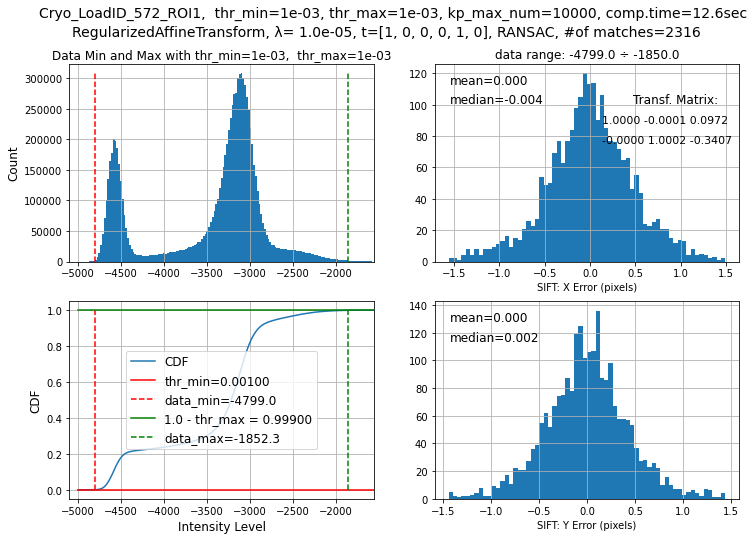

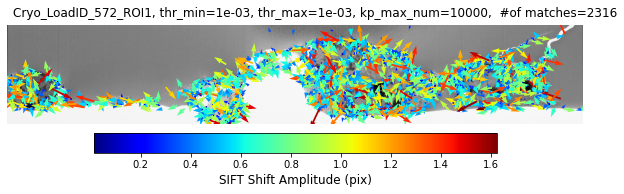

In [3]:
%%time
SIFT_evaluation_results = test_dataset.SIFT_evaluation()

# Now Perform SIFT Computations using DASK Distributed (local cluster, using SCATTER, MAP and GATHER)

# Step 1: Set up Local DASK Client and Monitor Window

In [4]:
#start / restart client
try:
    client.restart()
except:
    client = Client()
    
# setup a window to monitor the client progress
try:
    dport = client.scheduler_info()['services']['dashboard']
except:
    dport = client.scheduler_info()['services']['bokeh']
print('Using Local Port:   ', dport)
status_update_address = 'http://localhost:{:d}/status'.format(dport)
IFrame(src=status_update_address, width='100%', height='900px')

C:\ProgramData\Anaconda3\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53338 instead
  warnings.warn(


Using Local Port:    53338


# Step 2a: Save InLens.tif Data (Optional)

In [5]:
if save_data_as_tiff:
    test_dataset.convert_raw_data_to_tif_files(client)

# Step 2: Calculate the Global Data Range

Step 2: Calculate the Global Data Range
Using DASK distributed
Step 2: Elapsed time: 1150.08 seconds
Global Data Range for I8 conversion:  Min=-4832.93, Max=-1544.61


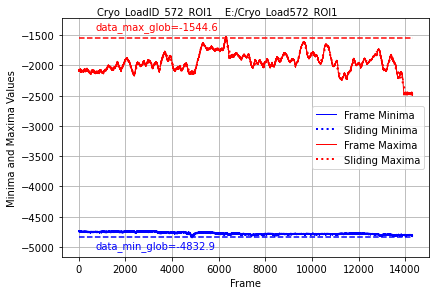

In [6]:
# Step 2: Calculate the Global Data Range

t0 = time.time()
print('Step 2: Calculate the Global Data Range')
data_minmax =  test_dataset.calc_data_range(client)

t1 = time.time()
print('Step 2: Elapsed time: {:.2f} seconds'.format(t1 - t0))
print('Global Data Range for I8 conversion:  Min={:.2f}, Max={:.2f}'.format(data_minmax[0], data_minmax[1]))

# Steps 3 and 4: Extract Key Points and Descriptors, Find Matches and Transformations

Step 3: Extract Key Points and Descriptors
Using DASK distributed
Step 3: Elapsed time: 3384.88 seconds

Step 4: Select Good Matches with FLANN matcher
Step 4: using RegularizedAffineTransform Transformation Model with RANSAC solver
Step 4: RegularizedAffineTransform parameters:
Step 4: Regularization matrix: 
[[1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
Step 4: Target Solution:  [1 0 0 0 1 0]
Using DASK distributed
Mean Number of Keypoints : 1932


Calculating Original Cummilative Transformation Matrix:   0%|          | 0/14311 [00:00<?, ?it/s]

Recalculating the transformation matrix for preserved scales


Recalculating the shifts for preserved scales:   0%|          | 0/14311 [00:00<?, ?it/s]

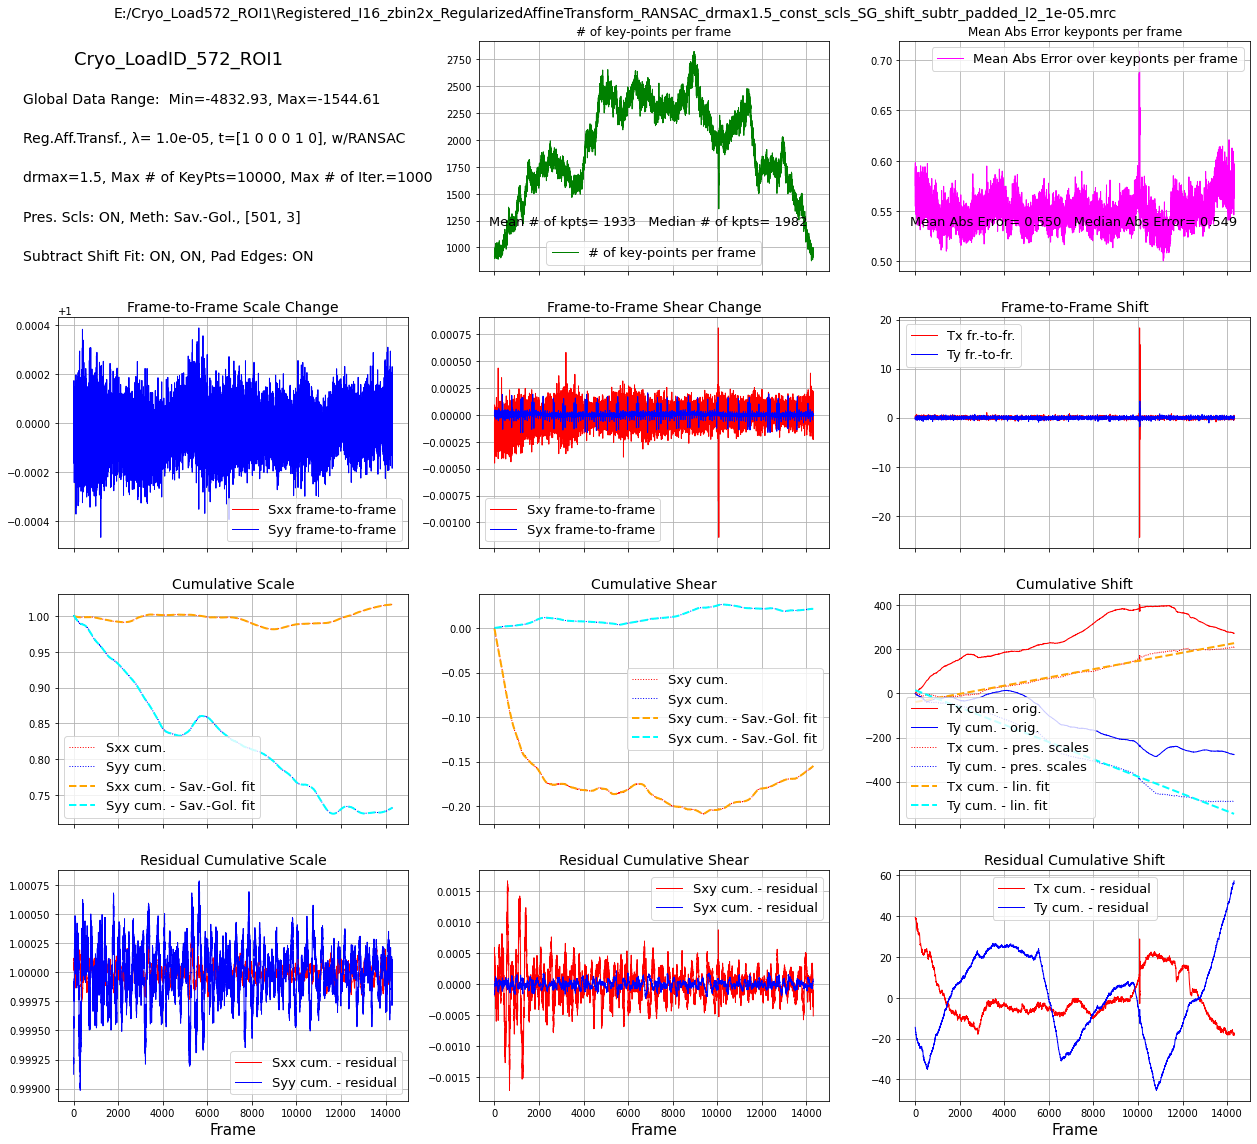

In [7]:
# Step 3: Extract Key Points and Descriptors using DASK Distributed
t1 = time.time()
print('Step 3: Extract Key Points and Descriptors')
fnms = test_dataset.extract_keypoints(client)   
t2 = time.time()
print('Step 3: Elapsed time: {:.2f} seconds'.format(t2 - t1))
print('')

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
matcher_str = 'BF' if BFMatcher else 'FLANN'
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + test_dataset.TransformType.__name__ + ' Transformation Model with ' + solver + ' solver')
if TransformType == RegularizedAffineTransform:
    print('Step 4: ' + test_dataset.TransformType.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(test_dataset.l2_matrix)
    print('Step 4: Target Solution: ', test_dataset.targ_vector)

results_s4 = test_dataset.determine_transformations(client)
t3 = time.time()

tr_matr_cum_residual = test_dataset.process_transformation_matrix()

In [8]:
# here is an example of how the previous step can be modified easily without having to re-do all previous steps
# this will calculate the cumulative transformation matrix WITHOT modifying the object property subtract_linear_fit
# so this change will NOT propagate.
# tr_matr_cum_residual = test_dataset.process_transformation_matrix(subtract_linear_fit = [False, True])

# if you want to make permanet change, then you should do this:
# test_dataset.subtract_linear_fit = [False, True]
# tr_matr_cum_residual = test_dataset.process_transformation_matrix()


# Step 5: Search for frames with no (or low # of) matches and possibly remove them.

In [9]:
thr_npt = 3   # consider frame with less than 3 Key Points for removal
tr_matr_cum_residual = test_dataset.check_for_nomatch_frames(thr_npt, **SIFT_kwargs)

Frames with no matches to the next frame:   []
Frames to remove:   []
No frames selected for removal


# Step 6: Recall or Save the Intermediate Data (KeyPoints, Matches, Transf.Matrix, etc.) from / into spreadsheets and a binary files.  Remove the intermediate KeyPoint/Descriptor files.

In [10]:
recall_the_data = False          # if False, the data will be saved. if True, the data will be recalled

dump_filename = os.path.join(data_dir, test_dataset.fnm_reg.replace('.mrc', '_params.bin'))

if recall_the_data:
    test_dataset = FIBSEM_dataset(fls, recall_parameters=True, dump_filename=dump_filename, **SIFT_kwargs)
else:
    saved_dump_file = test_dataset.save_parameters(dump_file=dump_filename)
    print('Parameters saved into the file: ', saved_dump_file)

Parameters saved into the file:  E:/Cryo_Load572_ROI1\Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_params.bin


In [11]:
remove_key_points_data = False   # if True, the binary files with intermediate keypoints data for each frame will be removed

# Remove temporary files
if remove_key_points_data:
    # Remove the keypoint/ descriptor files
    for fnm in tqdm(fnms, desc='Removing KeyPoint/Descriptor Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass
    for fnm in tqdm(fnms_matches, desc='Removing Matched KeyPoint Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass


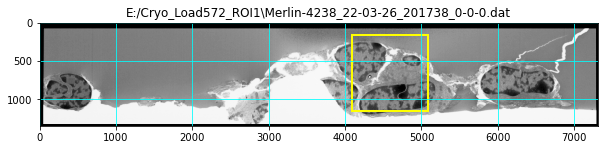

In [12]:
#evaluation_box = [250, 2000, 1450, 2650]      # optional evaluation box for defining the area over which the registration quality
#test_dataset.show_eval_box(evaluation_box = evaluation_box, invert_data=False)
#
# default frames are three frames: 10% from the start, 50% from the start, and 90% from the start
# alternatively you can set any list of frame indecis by using keyword frame_indices
# for example:0
# test_dataset.show_eval_box(frame_indices=[1, 100, 850], evaluation_box = evaluation_box, invert_data=False)
#
evaluation_box = [100, 1000, 4050, 1000] 
test_dataset.show_eval_box(invert_data=False, frame_inds=[len(fls)//2], evaluation_box=evaluation_box)

Analyzing Auto-Correlation SNRs :   0%|          | 0/1 [00:00<?, ?it/s]

Re-analyzing Auto-Correlation SNRs for fused image:   0%|          | 0/1 [00:00<?, ?it/s]

(0.04989725265355677, 0.06696120190247339, 0.07005596019949893)

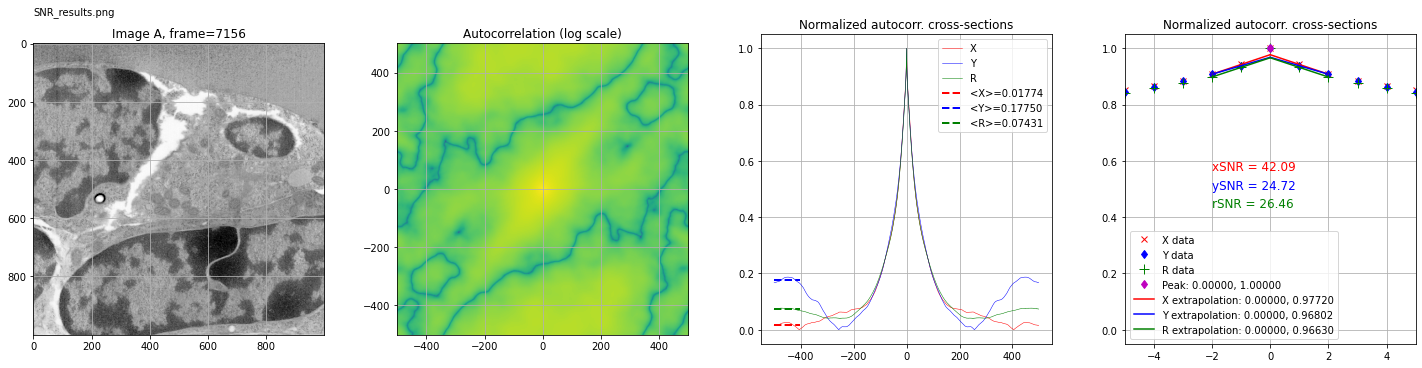

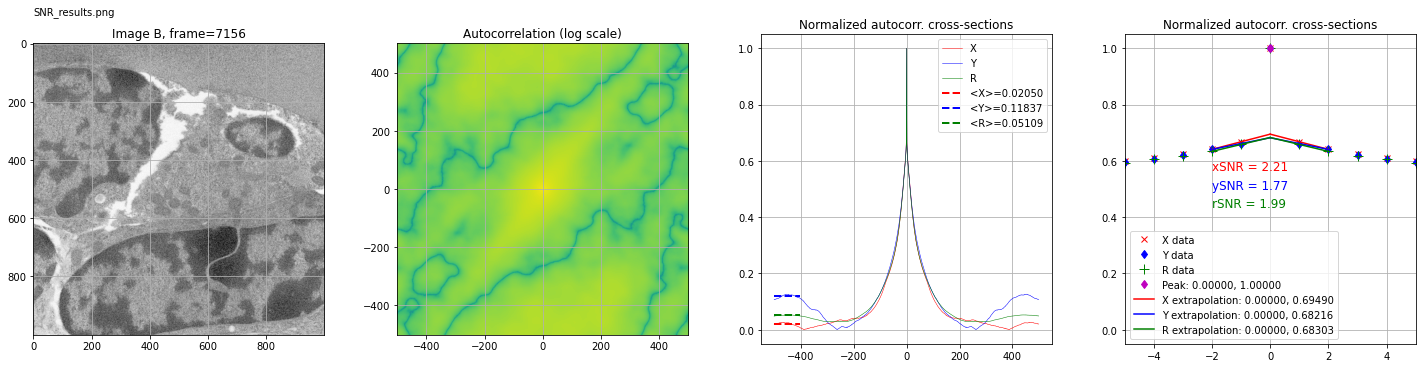

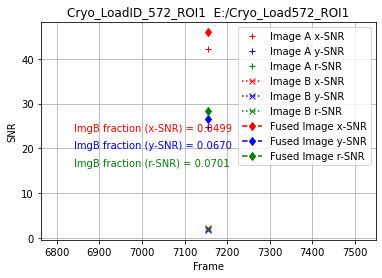

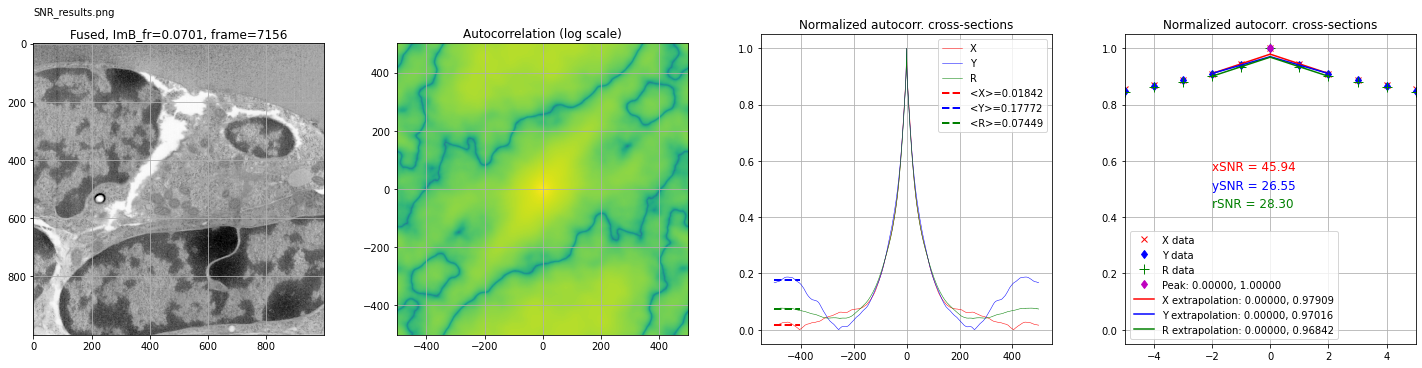

In [13]:
test_dataset.estimate_SNRs(frame_inds=[len(fls)//2], evaluation_box=evaluation_box)

Evaluating Img B fractions:   0%|          | 0/13 [00:00<?, ?it/s]

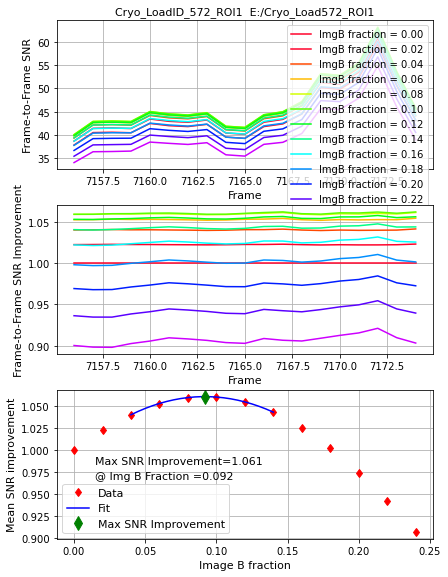

In [14]:
frame_inds = np.arange(20) + len(test_dataset.fls)//2
ImgB_fractions = np.linspace(0, 0.24, 13)
ImgB_fr_optimal_mid = test_dataset.evaluate_ImgB_fractions(ImgB_fractions, frame_inds, evaluation_box=evaluation_box)

# Step 7: Transform and Save the FIB-SEM data

Step 7: Transform and Save the FIB-SEM data
new reg file:  Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.mrc


Determining the pad offsets:   0%|          | 0/14312 [00:00<?, ?it/s]

Saving the registered and 2x z-binned stack into the file:  E:/Cryo_Load572_ROI1\Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.mrc


Saving into I16 MRC File:   0%|          | 0/7156 [00:00<?, ?it/s]

Wall time: 7h 41min 17s


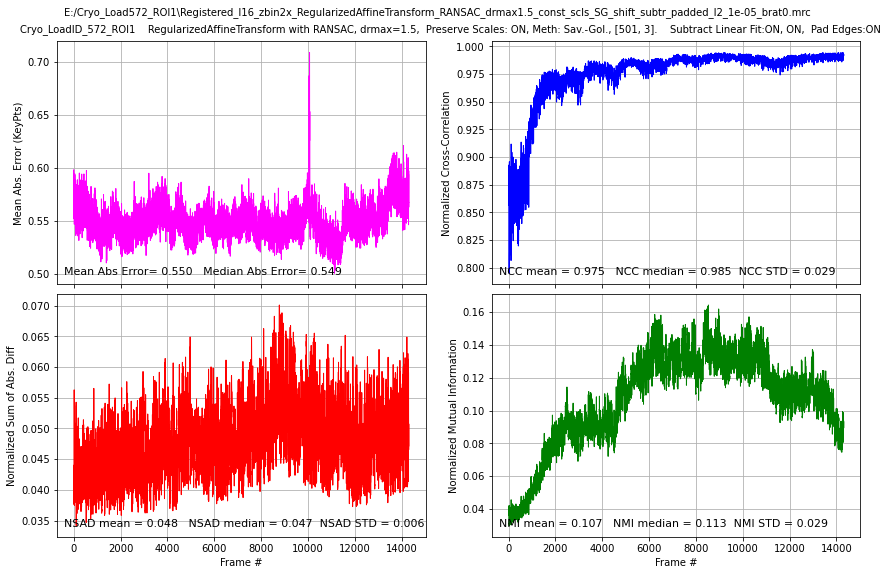

In [48]:
%%time

print('Step 7: Transform and Save the FIB-SEM data')

evaluation_box = [300, 800, 200, 7000]       # optional evaluation box for defining the area over which the registration quality
                                                # is evaluated. It can be checked in the step above. The use 
                                                # of the method below would be:
test_dataset.fnm_reg = 'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.mrc'
print('new reg file: ',test_dataset.fnm_reg)
    
reg_summary = test_dataset.transform_and_save(ImgB_fraction=0.0, evaluation_box = [300, 800, 200, 7000]) # following additional keys are available:
                                                #
                                                # perfrom_transformation (default=True). Set to false if you want to save the raw data into a single stack
                                                # and evaluare raw registration quality
                                                #
                                                # invert_data (default=False). Set to True if you want to invert te data
                                                #
                                                # evaluation_box (default [0, -1, 0, -1]. Set boundaries ([top, height, left, width]))
                                                # of the image subset to be used for registration quality evaluation


original reg file:  Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.10.mrc
new reg file:  Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.001.mrc


Determining the pad offsets:   0%|          | 0/14312 [00:00<?, ?it/s]

Saving the registered and 2x z-binned stack into the file:  E:/Cryo_Load572_ROI1\Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.001.mrc


Saving into I16 MRC File:   0%|          | 0/7156 [00:00<?, ?it/s]

Wall time: 8h 25min 43s


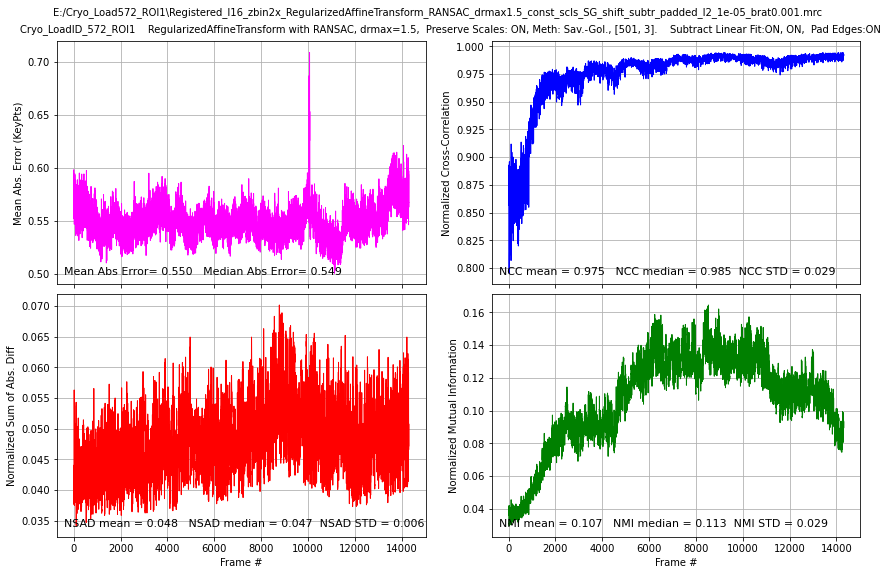

In [37]:
%%time
print('original reg file: ',test_dataset.fnm_reg)
test_dataset.fnm_reg = 'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.001.mrc'
print('new reg file: ',test_dataset.fnm_reg)
reg_summary_brat0p1 = test_dataset.transform_and_save(ImgB_fraction=0.001, evaluation_box = [300, 800, 200, 7000]) # following additional keys are available:
                                                #
                                                # perfrom_transformation (default=True). Set to false if you want to save the raw data into a single stack
                                                # and evaluare raw registration quality
                                                #
                                                # invert_data (default=False). Set to True if you want to invert te data
                                                #
                                                # evaluation_box (default [0, -1, 0, -1]. Set boundaries ([top, height, left, width]))
                                                # of the image subset to be used for registration quality evaluation

original reg file:  Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.mrc
new reg file:  Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.10.mrc


Determining the pad offsets:   0%|          | 0/14312 [00:00<?, ?it/s]

Saving the registered and 2x z-binned stack into the file:  E:/Cryo_Load572_ROI1\Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.10.mrc


Saving into I16 MRC File:   0%|          | 0/7156 [00:00<?, ?it/s]

Wall time: 8h 21min 58s


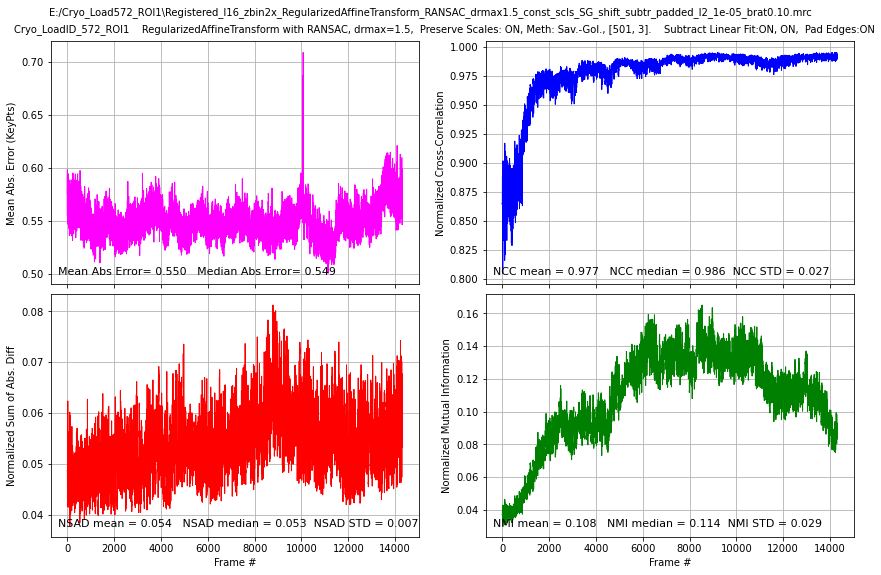

In [34]:
%%time
print('original reg file: ',test_dataset.fnm_reg)
test_dataset.fnm_reg = 'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.10.mrc'
print('new reg file: ',test_dataset.fnm_reg)
reg_summary_brat0p1 = test_dataset.transform_and_save(ImgB_fraction=0.10, evaluation_box = [300, 800, 200, 7000]) # following additional keys are available:
                                                #
                                                # perfrom_transformation (default=True). Set to false if you want to save the raw data into a single stack
                                                # and evaluare raw registration quality
                                                #
                                                # invert_data (default=False). Set to True if you want to invert te data
                                                #
                                                # evaluation_box (default [0, -1, 0, -1]. Set boundaries ([top, height, left, width]))
                                                # of the image subset to be used for registration quality evaluation


original reg file:  Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.07.mrc
new reg file:  Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.12.mrc


Determining the pad offsets:   0%|          | 0/14312 [00:00<?, ?it/s]

Saving the registered and 2x z-binned stack into the file:  E:/Cryo_Load572_ROI1\Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.12.mrc


Saving into I16 MRC File:   0%|          | 0/7156 [00:00<?, ?it/s]

Wall time: 8h 9min 26s


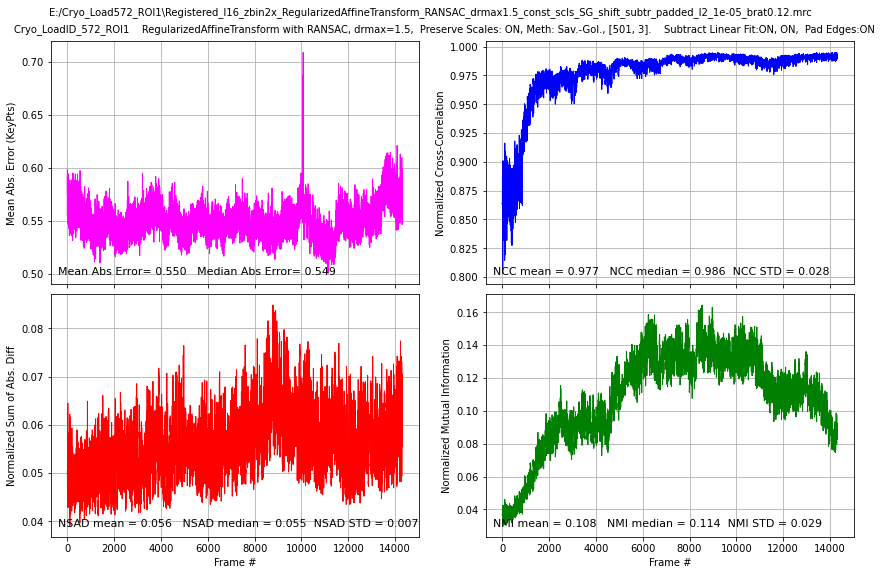

In [25]:
%%time
print('original reg file: ',test_dataset.fnm_reg)
test_dataset.fnm_reg = 'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.12.mrc'
print('new reg file: ',test_dataset.fnm_reg)
reg_summary_brat0p1 = test_dataset.transform_and_save(ImgB_fraction=0.12, evaluation_box = [300, 800, 200, 7000]) # following additional keys are available:
                                                #
                                                # perfrom_transformation (default=True). Set to false if you want to save the raw data into a single stack
                                                # and evaluare raw registration quality
                                                #
                                                # invert_data (default=False). Set to True if you want to invert te data
                                                #
                                                # evaluation_box (default [0, -1, 0, -1]. Set boundaries ([top, height, left, width]))
                                                # of the image subset to be used for registration quality evaluation


original reg file:  Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.12.mrc
new reg file:  Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.04.mrc


Determining the pad offsets:   0%|          | 0/14312 [00:00<?, ?it/s]

Saving the registered and 2x z-binned stack into the file:  E:/Cryo_Load572_ROI1\Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.04.mrc


Saving into I16 MRC File:   0%|          | 0/7156 [00:00<?, ?it/s]

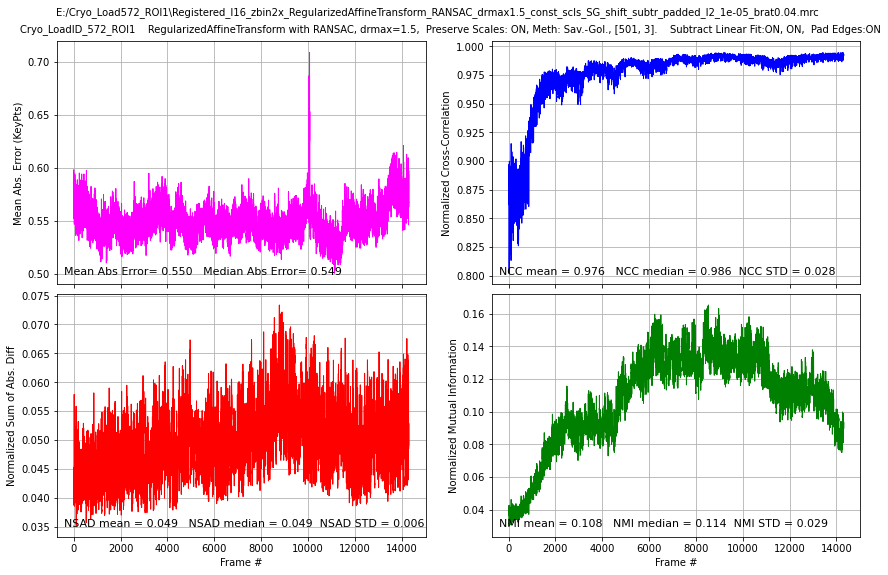

In [27]:
print('original reg file: ',test_dataset.fnm_reg)
test_dataset.fnm_reg = 'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.04.mrc'
print('new reg file: ',test_dataset.fnm_reg)
reg_summary_brat0p1 = test_dataset.transform_and_save(ImgB_fraction=0.040, evaluation_box = [300, 800, 200, 7000]) # following additional keys are available:
                                                #
                                                # perfrom_transformation (default=True). Set to false if you want to save the raw data into a single stack
                                                # and evaluare raw registration quality
                                                #
                                                # invert_data (default=False). Set to True if you want to invert te data
                                                #
                                                # evaluation_box (default [0, -1, 0, -1]. Set boundaries ([top, height, left, width]))
                                                # of the image subset to be used for registration quality evaluation


generating the registration quality summary plots:   0%|          | 0/7 [00:00<?, ?it/s]

generating the summary table: 0it [00:00, ?it/s]

saving the data into xlsx file:   0%|          | 0/7 [00:00<?, ?it/s]

'E:/Cryo_Load572_ROI1\\Regstration_Summary.xlsx'

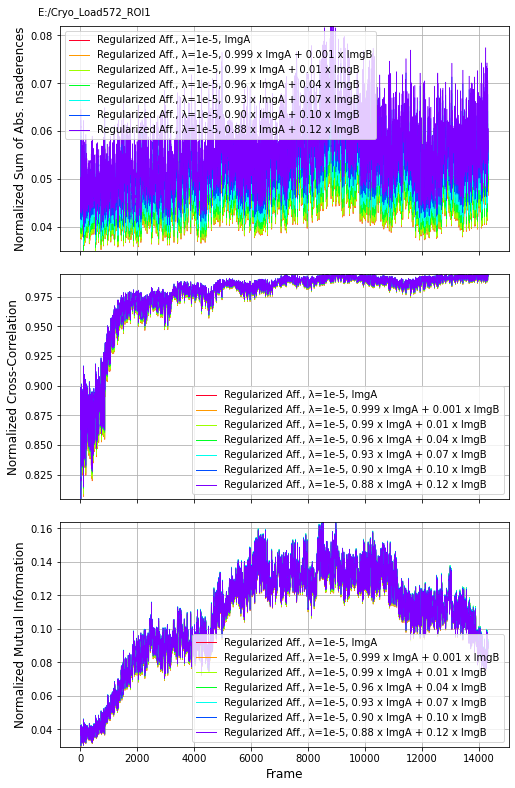

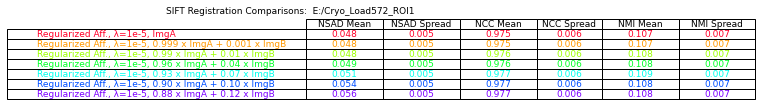

In [49]:
data_dir = 'E:/Cryo_Load572_ROI1'
data_files = ['Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0_RegistrationQuality.csv',
              'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.001_RegistrationQuality.csv',
              'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.01_RegistrationQuality.csv',
              'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.04_RegistrationQuality.csv',
              'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.07_RegistrationQuality.csv',
              'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.10_RegistrationQuality.csv',
             'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.12_RegistrationQuality.csv']

reg_qual_fls = [os.path.join(data_dir, df) for df in data_files]
nfls = len(reg_qual_fls)

pfs = ['Regularized Aff., λ=1e-5, ImgA',
       'Regularized Aff., λ=1e-5, 0.999 x ImgA + 0.001 x ImgB',
       'Regularized Aff., λ=1e-5, 0.99 x ImgA + 0.01 x ImgB',
       'Regularized Aff., λ=1e-5, 0.96 x ImgA + 0.04 x ImgB',
       'Regularized Aff., λ=1e-5, 0.93 x ImgA + 0.07 x ImgB',
       'Regularized Aff., λ=1e-5, 0.90 x ImgA + 0.10 x ImgB',
      'Regularized Aff., λ=1e-5, 0.88 x ImgA + 0.12 x ImgB']

plot_registrtion_quality_csvs(reg_qual_fls, pfs)

In [55]:
print('Average SNR with Image B fraction = 0.00:   {:.2f}'.format(0.977/(1-0.977)))
print('Average SNR with Image B fraction = 0.07:   {:.2f}'.format(0.975/(1-0.975)))
print('Average SNR improvement:   {:.3f}'.format(0.977/(1-0.977)/(0.975/(1-0.975))))

SNR with Image B fraction = 0.00:   42.48
SNR with Image B fraction = 0.07:   39.00
SNR improvement:   1.089


In [6]:
data_dir = 'E:/Cryo_Load572_ROI1'
data_files = ['Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0_RegistrationQuality.csv',
              'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.001_RegistrationQuality.csv',
              'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.01_RegistrationQuality.csv',
              'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.04_RegistrationQuality.csv',
              'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.07_RegistrationQuality.csv',
              'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.10_RegistrationQuality.csv',
             'Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_brat0.12_RegistrationQuality.csv']
reg_qual_fls = [os.path.join(data_dir, df) for df in data_files]

In [7]:
file_csv = 'Y:/Cryo_data/EM_data/20161004/20161004_S3_cell11_raw/20161004_S3_cell11/Registered_I8_RegAffine_l2_1e-05_brat0.00_RegistrationQuality.csv'
data = pd.read_csv(file_csv)

In [8]:
data.head()

,Frame,Npts,Mean Abs Error,Image NSAD,Image NCC,Image MI
0,0.0,60.00,0.664848,3.957258,0.963769,0.123300
1,1.0,63.00,0.671865,3.765766,0.964163,0.124259
2,2.0,64.50,0.628030,3.954664,0.965593,0.126107
3,3.0,60.25,0.643422,3.988507,0.966332,0.127170
4,4.0,60.50,0.644383,3.945946,0.969736,0.130697


In [19]:
xi_eval = [1000, 1100, 1200]
xa_eval = [2000, 2200, 2300]
yi_eval = [3000, 3000, 3000]
ya_eval = [5000, 5000, 5000]
eval_frames = [10, 20, 30]


file_xls = 'Y:/Cryo_data/EM_data/20161004/20161004_S3_cell11_raw/20161004_S3_cell11/Registered_I8_RegAffine_sum.xlsx'
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(file_xls, engine='xlsxwriter')

data.to_excel(writer, index=None, sheet_name='Registration Quality Statistics')
Stack_info = pd.DataFrame([{'Stack Filename' : 'Registered_I8_RegAffine_l2_1e-05_brat0.12.mrc', 'data_dir' : data_dir}])
Stack_info.to_excel(writer, index=None, sheet_name='Stack Info')

Eval_info = pd.DataFrame(np.vstack((eval_frames, xi_eval, xa_eval, yi_eval, ya_eval)).T,
                           columns = ['Eval. Frames', 'xi_eval', 'xa_eval', 'yi_eval', 'ya_eval'], index = None)
Eval_info.to_excel(writer, index=None, sheet_name='Evaluation info')

df_kwargs = pd.DataFrame([SIFT_kwargs]).T
df_kwargs.to_excel(writer, header=False, sheet_name='SIFT kwargs')

writer.save()

In [20]:
df_kwargs

,0
BFMatcher,False
EightBit,1
Lowe_Ratio_Threshold,0.7
SIFT_contrastThreshold,0.025
SIFT_edgeThreshold,10
SIFT_nOctaveLayers,3
SIFT_nfeatures,100000
SIFT_sigma,1.6
Sample_ID,Cryo 20161004_S3_Cell11
TransformType,<class 'SIFT_gs.FIBSEM_SIFT_gs.RegularizedAffi...


In [21]:
new_Regisration_data = pd.read_excel(file_xls, sheet_name='Registration Quality Statistics')
new_Stack_Info = pd.read_excel(file_xls, sheet_name='Stack Info')
new_Eval_info = pd.read_excel(file_xls, sheet_name='Evaluation info')
new_kwargs = pd.read_excel(file_xls, index_col=0, sheet_name='SIFT kwargs').T
SIFT_dict = {}
for key in new_kwargs.keys():
    SIFT_dict[key] = new_kwargs[key][0]

In [22]:
new_kwargs

BFMatcher,EightBit,Lowe_Ratio_Threshold,SIFT_contrastThreshold,SIFT_edgeThreshold,SIFT_nOctaveLayers,SIFT_nfeatures,SIFT_sigma,Sample_ID,TransformType,data_dir,...,save_res_png,sliding_minmax,solver,subtract_linear_fit,suffix,targ_vector,threshold_max,threshold_min,use_DASK,zbin_factor
False,1,0.7,0.025,10,3,100000,1.6,Cryo 20161004_S3_Cell11,<class 'SIFT_gs.FIBSEM_SIFT_gs.RegularizedAffi...,Y:/Cryo_data/EM_data/20161004/20161004_S3_cell...,...,1,1,RANSAC,"[True, True]",l2_1e-05,[1 0 0 0 1 0],0.001,0.001,1,4


In [18]:
new_kwargs.keys()

Index(['BFMatcher', 'EightBit', 'Lowe_Ratio_Threshold',
       'SIFT_contrastThreshold', 'SIFT_edgeThreshold', 'SIFT_nOctaveLayers',
       'SIFT_nfeatures', 'SIFT_sigma', 'Sample_ID', 'TransformType',
       'data_dir', 'drmax', 'fit_params', 'ftype', 'int_order', 'kp_max_num',
       'l2_matrix', 'max_iter', 'nbins', 'pad_edges', 'preserve_scales',
       'save_asI8', 'save_data_as_tiff', 'save_matches', 'save_res_png',
       'sliding_minmax', 'solver', 'subtract_linear_fit', 'suffix',
       'targ_vector', 'threshold_max', 'threshold_min', 'use_DASK',
       'zbin_factor'],
      dtype='object')

In [75]:
SIFT_dict = {}
for key in new_kwargs.keys():
    SIFT_dict[key] = new_kwargs[key][0]

In [74]:
new_kwargs.keys()

Index(['BFMatcher', 'EightBit', 'Lowe_Ratio_Threshold',
       'SIFT_contrastThreshold', 'SIFT_edgeThreshold', 'SIFT_nOctaveLayers',
       'SIFT_nfeatures', 'SIFT_sigma', 'Sample_ID', 'TransformType',
       'data_dir', 'drmax', 'fit_params', 'ftype', 'int_order', 'kp_max_num',
       'l2_matrix', 'max_iter', 'nbins', 'pad_edges', 'preserve_scales',
       'save_asI8', 'save_data_as_tiff', 'save_matches', 'save_res_png',
       'sliding_minmax', 'solver', 'subtract_linear_fit', 'suffix',
       'targ_vector', 'threshold_max', 'threshold_min', 'use_DASK',
       'zbin_factor'],
      dtype='object')

In [82]:
new_Stack_Info['Stack Filename'][0], new_Stack_Info['data_dir'][0]

('Registered_I8_RegAffine_l2_1e-05_brat0.12.mrc',
 'Y:/Cryo_data/EM_data/20161004/20161004_S3_cell11_raw/20161004_S3_cell11')

In [79]:
xx = SIFT_dict.get('BFMatcher', True)
print(xx)
xy = SIFT_dict.get('BFatcher', True)
print(xy)

False
True


In [41]:
new_Eval_info

,Eval. Frames,xi_eval,xa_eval,yi_eval,ya_eval
0,10,1000,2000,3000,5000
1,20,1100,2200,3000,5000
2,30,1200,2300,3000,5000


In [54]:
SIFT_kwargs = new_kwargs.to_dict(orient='list')
SIFT_kwargs['BFMatcher']

[False]

In [70]:
new_kwargs['BFMatcher'][0]

False

In [58]:
new_kwargs

,BFMatcher,EightBit,Lowe_Ratio_Threshold,SIFT_contrastThreshold,SIFT_edgeThreshold,SIFT_nOctaveLayers,SIFT_nfeatures,SIFT_sigma,Sample_ID,TransformType,...,save_res_png,sliding_minmax,solver,subtract_linear_fit,suffix,targ_vector,threshold_max,threshold_min,use_DASK,zbin_factor
0,False,1,0.7,0.025,10,3,100000,1.6,Cryo 20161004_S3_Cell11,<class 'SIFT_gs.FIBSEM_SIFT_gs.RegularizedAffi...,...,True,True,RANSAC,"[True, True]",l2_1e-05,[1 0 0 0 1 0],0.001,0.001,True,4


In [ ]:
df_kwargs = pd.DataFrame({"kwargs": keys, "Values": values})